In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
import cv2
import time

In [2]:
rc_sum= ctypes.CDLL("./build/librc_sum.so").rc_sum

In [3]:
rc_sum.restype = None
class Image(ctypes.Structure):
    _fields_ = [('data', ctypes.POINTER(ctypes.c_uint16)),
                ('rows', ctypes.c_size_t),
                ('cols', ctypes.c_size_t)]

class RoI(ctypes.Structure):
    _fields_ = [
    ('x', ctypes.c_int),
    ('y', ctypes.c_int),
    ('w' ,ctypes.c_int),
    ('h', ctypes.c_int)
    ]
    
rc_sum.argtypes = [Image, RoI, ctypes.POINTER(ctypes.c_uint16), ctypes.POINTER(ctypes.c_uint16)]

def select_roi(x, y, w, h):
    return np.s_[int(y):int(y)+h, int(x):int(x)+w]

FPS cpp: 3497.200372888267
FPS np: 2508.6485234362744


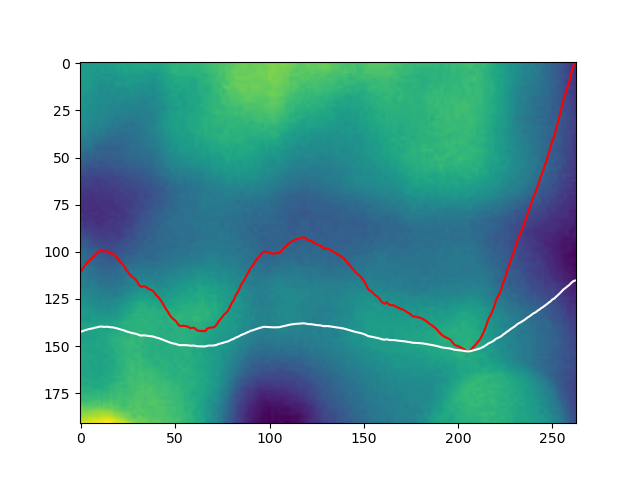

In [7]:
%matplotlib widget
image = cv2.imread("/home/joris/Downloads/test.jpeg", cv2.IMREAD_GRAYSCALE)
image_h, image_w = image.shape

roi = cv2.selectROI(image)
cv2.waitKey(1)
cv2.destroyAllWindows()
x, y, w, h = roi

row_sum = np.zeros(w, dtype=np.uint16)
col_sum = np.zeros(h, dtype=np.uint16)
c_image = Image(image.astype('uint16').ctypes.data_as(ctypes.POINTER(ctypes.c_uint16)), image_h, image_w)
c_roi = RoI(x, y, w, h)
c_row_sum = row_sum.ctypes.data_as(ctypes.POINTER(ctypes.c_uint16))
c_col_sum = col_sum.ctypes.data_as(ctypes.POINTER(ctypes.c_uint16))
start = time.perf_counter()
rc_sum(c_image, c_roi, c_row_sum, c_col_sum)
end = time.perf_counter()
roi = image[select_roi(x, y, w, h)]
start2 = time.perf_counter()
row_sum_np = np.sum(roi, axis=0)
col_sum_np = np.sum(roi, axis=1)
end2 = time.perf_counter()
plt.imshow(image[select_roi(x, y, w, h)])
row_sum_plot = (row_sum - np.min(row_sum))
row_sum_plot = row_sum_plot/np.max(row_sum_plot) * 0.8 * h
row_sum_plot_np = (row_sum_np - np.min(row_sum_np))
row_sum_plot_np = row_sum_plot_np/np.max(row_sum_plot_np) * 0.8 * h
plt.plot(row_sum_plot, 'r')
plt.plot(row_sum_np/np.max(row_sum_np)*h*0.8, 'w')
print(f"FPS cpp: {1/(end -start)}")
print(f"FPS np: {1/(end2 -start2)}")